## Summary:
1. Applied stopword removal function to clean up the text review data(remove the punctuations, digits and stopwords)
2. Used TF-IDF vectorizer to transform the text data into feature vectors
3. Built Multinomial Naive Bayes, Logistic Regression, Random Forest and Neural Network models to predict the positive/negative sentiment based on users' text reviews
4. Model evaluation: Logistic Regression and Neural Network yield almost the same highest accuracy; surprisingly Multinomial Naive Bayes has the second highest accuracy and is super fast to train.

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import nltk
import string
from nltk.corpus import stopwords
import re

In [6]:
df=pd.read_csv('business_user_review_2017.csv')

In [26]:
review=df.loc[df['date']>='2017-07-01',['text','pos_neg']].copy()

In [27]:
review=review.dropna()

In [28]:
review.isnull().sum()

text       0
pos_neg    0
dtype: int64

In [33]:
def remove_stopwords (text):
    i = nltk.corpus.stopwords.words('english')
# punctuations to remove
    j = list(string.punctuation)
# string for facial expressions to remove
    #emoticons= re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',text)
# combine all stopwords
    stopwords = set(i).union(j).union(('thiswas','thisis','wasgood','isbad','wasbad','isgood','theres','there','order','restaurant','one','got','place'))
# clean up some special strings from web (numbers, non-character values)
    text= re.sub('<[^>]*>','',text)
    text= re.sub('[\d]+','',text)
    text= re.sub('[\W]+',' ',text.lower())
    text = [w for w in text.split() if w not in set(stopwords)] 
    return ' '.join(text)

In [11]:
#test
text=':)I like this place.its very nice!:)thiswas the place I go 100%'
remove_stopwords(text)

'like nice go'

In [38]:
#example of a review in original text
review.iloc[55,0]

"Been here several times. This is definitely our go to place in Vegas. Awesome service! Steaks are the best I've had. We like to try different places but we always have to go to Delmonico while in Vegas."

In [39]:
review['text_clean']=review['text'].apply(remove_stopwords)
#check how the function works on a single review text
review.iloc[55,2]

'several times definitely go vegas awesome service steaks best like try different places always go delmonico vegas'

In [40]:
review.head()

,text,pos_neg,text_clean
--6MefnULPED_I942VcFNA,This is one of my top 3 places to get BBQ pork...,1,top places get bbq pork char siu cheapest opti...
--6MefnULPED_I942VcFNA,I walked by the restaurant more than 5 years a...,0,walked years ago witnessed window employees dr...
--6MefnULPED_I942VcFNA,Thanks to the grumpy ass old lady for telling ...,0,thanks grumpy ass old lady telling like pieces...
--6MefnULPED_I942VcFNA,"After years of going to Lung Tung BBQ, and bei...",1,years going lung tung bbq disappointed uneven ...
--6MefnULPED_I942VcFNA,Of the 6 Cantonese BBQ places I have tried in ...,1,cantonese bbq places tried gta far best wants ...


In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

In [42]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = \
train_test_split(review['text_clean'], review['pos_neg'], random_state = 1, test_size=0.3)

### 1.0 Apply TF-IDF Vectorizer to transform the text reviews to feature vectors

In [49]:
tfidfvct=TfidfVectorizer(analyzer = 'word',ngram_range=(1,1),max_features=20000)
#fit_transform training text
train_matrix=tfidfvct.fit_transform(x_train)
#transform test text
test_matrix=tfidfvct.transform(x_test)

In [50]:
train_matrix.shape

(384738, 20000)

In [51]:
words = tfidfvct.get_feature_names()

### 2.0 Fit different algrithms to predict the sentiment(positive/negative) based on the reviews

### 2.1 Multinomial Naive Bayes Classifier
> Usually this model works well when data size is small and it assumes independence between words. Obviously it's not the case here. But it can serve as a baseline model

In [54]:
#from sklearn.naive_bayes import MultinomialNB
clf_NB = MultinomialNB()
clf_NB.fit(train_matrix, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [66]:
NB_pred=clf_NB.predict(test_matrix)
NB_prob=clf_NB.predict_proba(test_matrix)[:,1]

In [56]:
print('The MultinomialNB accuracy score for train data set is %f, for test data set is: %f' % \
     (clf_NB.score(train_matrix, y_train), clf_NB.score(test_matrix, y_test)))

The MultinomialNB accuracy score for train data set is 0.887006, for test data set is: 0.884018


#### * Helper function to print metric scores 

In [62]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score
   
def get_performance_metrics(y_test, y_test_pred, threshold=0.5):
    metric_names = ['AUC','Accuracy','Precision','Recall','f1-score']
   
    metric_values_test = [roc_auc_score(y_test, y_test_pred),
                    accuracy_score(y_test, y_test_pred>threshold),
                    precision_score(y_test, y_test_pred>threshold),
                    recall_score(y_test, y_test_pred>threshold),
                    f1_score(y_test, y_test_pred>threshold)
                   ]
    all_metrics = pd.DataFrame({'metrics':metric_names,
                                
                                'test':metric_values_test},columns=['metrics','test']).set_index('metrics')
    print(all_metrics)

In [63]:
get_performance_metrics(y_test, NB_pred, threshold=0.5)

               test
metrics            
AUC        0.840148
Accuracy   0.884018
Precision  0.877934
Recall     0.962973
f1-score   0.918489


#### * Helper function for ROC curve

In [94]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_test, y_test_prob,model):
    
    roc_auc_test = roc_auc_score(y_test, y_test_prob)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
    plt.figure()
    lw = 2
    plt.plot(fpr_test, tpr_test, color='darkorange',
             lw=lw, label='ROC Test (AUC = %0.4f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for '+model)
    plt.legend(loc="lower right")
    plt.show()

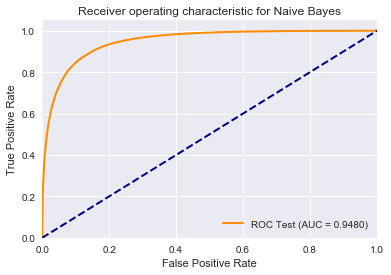

In [76]:
plot_roc_curve(y_test, NB_pred,'Naive Bayes') ## baseline model is not bad at all

### 2.2 Logistic Regression Classifier
> Great for binary Classification problem. relatively fast to train

In [57]:
#from sklearn.linear_model import LogisticRegression
clf_LR = LogisticRegression(C=10, n_jobs = -1, verbose = 1)
clf_LR.fit(train_matrix, y_train)

/Users/xueyiwen/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=1, warm_start=False)

In [58]:
LR_pred=clf_LR.predict(test_matrix)
print('The LogisticRegression accuracy score for train data set is %f, for test data set is: %f' % \
     (clf_LR.score(train_matrix, y_train), clf_LR.score(test_matrix, y_test)))

The LogisticRegression accuracy score for train data set is 0.935403, for test data set is: 0.917981


In [60]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score
# Helper method to print metric scores    
def get_performance_metrics(y_test, y_test_pred, threshold=0.5):
    metric_names = ['AUC','Accuracy','Precision','Recall','f1-score']
   
    metric_values_test = [roc_auc_score(y_test, y_test_pred),
                    accuracy_score(y_test, y_test_pred>threshold),
                    precision_score(y_test, y_test_pred>threshold),
                    recall_score(y_test, y_test_pred>threshold),
                    f1_score(y_test, y_test_pred>threshold)
                   ]
    all_metrics = pd.DataFrame({'metrics':metric_names,
                                
                                'test':metric_values_test},columns=['metrics','test']).set_index('metrics')
    print(all_metrics)

In [61]:
get_performance_metrics(y_test, LR_pred, threshold=0.5)

               test
metrics            
AUC        0.901096
Accuracy   0.917981
Precision  0.931961
Recall     0.948369
f1-score   0.940094


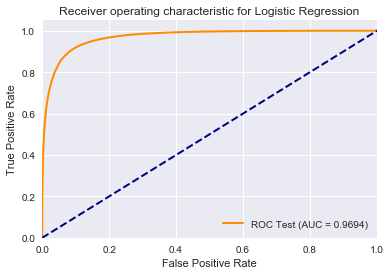

In [95]:
LR_prob=clf_LR.predict_proba(test_matrix)[:,1]
plot_roc_curve(y_test, LR_prob,'Logistic Regression')

In [85]:
def get_top_values(lst, n, labels):
    #Given a list of values, find the indices with the highest n values.
    #Return the labels for each of these indices.
    return [labels[i] for i in np.argsort(lst)[::-1][:n]]  

#### * Find top 20 influential words to sentiments

In [86]:
n = 20
print ('Top 20 words by ranking are \n%s.' % 
       (", ".join(i for i in get_top_values(clf_LR.coef_[0], n, words)))) 

Top 20 words by ranking are 
amazing, delicious, great, excellent, highly, thank, exceeded, perfect, gem, fantastic, awesome, phenomenal, best, knowledgeable, painless, love, happier, disappoint, heaven, wonderful.


* most of the top words are very positive!

### 2.4 Random Forest 

In [90]:
clf_RF = RandomForestClassifier(n_estimators=100, max_depth = 20, min_samples_leaf= 5, \
                                random_state = 12, n_jobs = -1, verbose = 1)
clf_RF.fit(train_matrix, y_train)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.7min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=12, verbose=1, warm_start=False)

In [91]:
RF_pred=clf_RF.predict(test_matrix)
get_performance_metrics(y_test, RF_pred, threshold=0.5)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.7s finished


               test
metrics            
AUC        0.639130
Accuracy   0.764943
Precision  0.745876
Recall     0.991376
f1-score   0.851280


In [92]:
print('The Random Forest accuracy score for train data set is %f, for test data set is: %f' % \
     (clf_RF.score(train_matrix, y_train), clf_RF.score(test_matrix, y_test)))

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    6.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s


The Random Forest accuracy score for train data set is 0.770979, for test data set is: 0.764943


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.8s finished


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.8s finished


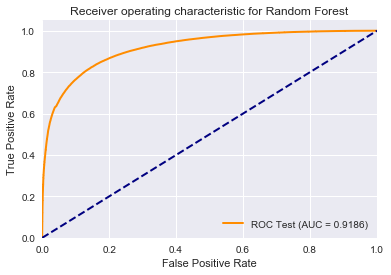

In [97]:
RF_prob=clf_RF.predict_proba(test_matrix)[:,1]
plot_roc_curve(y_test, RF_prob,'Random Forest')

### 2.5 Neural Network

In [98]:
from sklearn.neural_network import MLPClassifier

parameters = {
    'solver':'adam', 
    'activation':'relu',
    'alpha':1, #increase alpha->increase penalty
    'hidden_layer_sizes':(3,3), 
    'learning_rate':'adaptive',
    'random_state':1,
    'early_stopping': True
    }
clf_NN = MLPClassifier(**parameters)


In [100]:
clf_NN.fit(train_matrix,y_train)

MLPClassifier(activation='relu', alpha=1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 5), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [101]:
NN_pred=clf_NN.predict(test_matrix)
get_performance_metrics(y_test, NN_pred, threshold=0.5)

               test
metrics            
AUC        0.884950
Accuracy   0.911758
Precision  0.914249
Recall     0.960006
f1-score   0.936569


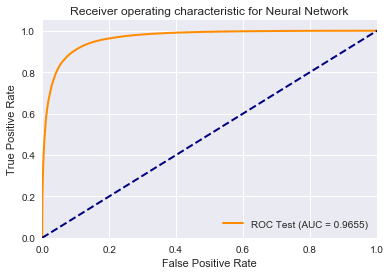

In [102]:
NN_prob=clf_NN.predict_proba(test_matrix)[:,1]
plot_roc_curve(y_test, NN_prob,'Neural Network')